In [1]:
import warnings
warnings.filterwarnings('ignore')

# ネットワーク図の作成

実際のアンケート結果の一部を用いて説明していきます。

使用するライブラリ
- pandas
- networkx
- matplotlib
- japanize_matplotlib

## まずはアンケート結果のCSV読み込みから

In [2]:
import pandas as pd 

filename = "data.csv"

 #csvファイルの読み込み。日本語が含まれるファイルはたいていutf-8-sigでエンコードすればなんとかなる
df = pd.read_csv(filename,encoding="utf-8-sig")

In [3]:
df.head()

,遊んだことのあるポケモン本編のゲームソフトにチェックを入れてください。,年齢を教えて下さい
0,"赤/緑/青 Red/Blue, ピカチュウ Yellow, 金/銀 Gold/Silver,...",20~
1,"赤/緑/青 Red/Blue, ピカチュウ Yellow, プラチナ Platinum, ハ...",20~
2,"赤/緑/青 Red/Blue, ピカチュウ Yellow, 金/銀 Gold/Silver,...",30~
3,"赤/緑/青 Red/Blue, ピカチュウ Yellow, 金/銀 Gold/Silver,...",30~
4,"赤/緑/青 Red/Blue, ピカチュウ Yellow, 金/銀 Gold/Silver,...",20~


## 列名を扱いやすいように変更しておく

In [4]:
df.columns = ["games","age"]
df.head()

,games,age
0,"赤/緑/青 Red/Blue, ピカチュウ Yellow, 金/銀 Gold/Silver,...",20~
1,"赤/緑/青 Red/Blue, ピカチュウ Yellow, プラチナ Platinum, ハ...",20~
2,"赤/緑/青 Red/Blue, ピカチュウ Yellow, 金/銀 Gold/Silver,...",30~
3,"赤/緑/青 Red/Blue, ピカチュウ Yellow, 金/銀 Gold/Silver,...",30~
4,"赤/緑/青 Red/Blue, ピカチュウ Yellow, 金/銀 Gold/Silver,...",20~


In [5]:
# nullがないか確認。games列に274のnullがあるらしいので補填しておく
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23000 entries, 0 to 22999
Data columns (total 2 columns):
games    22726 non-null object
age      23000 non-null object
dtypes: object(2)
memory usage: 359.5+ KB


In [6]:
df = df.fillna("-")

## データの加工

**games列に、遊んだことのあるポケモンタイトルの履歴が全て入っているようだ。
<br>
まずこれを加工していく**

In [7]:
print(df.iloc[0,0])

赤/緑/青 Red/Blue, ピカチュウ Yellow, 金/銀 Gold/Silver, クリスタル Crystal, ルビー/サファイア Ruby/Sapphire, ファイアレッド/リーフグリーン FireRed/LeafGreen, エメラルド Emerald, ダイヤモンド/パール Diamond/Pearl, プラチナ Platinum, ハートゴールド/ソウルシルバー HeartGold/SoulSilver, ブラック/ホワイト Black/White, ブラック2/ホワイト2  Black 2/White 2, X/Y, オメガルビー/アルファサファイア Omega Ruby/Alpha Sapphire, サン/ムーン Sun/Moon, ウルトラサン/ウルトラムーン Ultra Sun/Ultra Moon, ソード/シールド Sword/Shield


**「,」によって文字列を分割すれば、それぞれのタイトルに分かれそうだが、<br>
念の為もう少し調べてみよう**

In [8]:
df["len"] = df["games"].map(lambda text:len(text))
max_idx = df["len"].argmax() #文字列の最も長い行を検索。それで多くタイトルをプレイしている場合を確認する

print(df.loc[max_idx,"games"])

赤/緑/青 Red/Blue, ピカチュウ Yellow, 金/銀 Gold/Silver, クリスタル Crystal, ルビー/サファイア Ruby/Sapphire, ファイアレッド/リーフグリーン FireRed/LeafGreen, エメラルド Emerald, ダイヤモンド/パール Diamond/Pearl, プラチナ Platinum, ハートゴールド/ソウルシルバー HeartGold/SoulSilver, ブラック/ホワイト Black/White, ブラック2/ホワイト2  Black 2/White 2, X/Y, オメガルビー/アルファサファイア Omega Ruby/Alpha Sapphire, サン/ムーン Sun/Moon, ウルトラサン/ウルトラムーン Ultra Sun/Ultra Moon, Let's Go!ピカチュウ/Let's Go!イーブイ  Let's Go, Pikachu!/Let's Go, Eevee!, ソード/シールド Sword/Shield


「,」によって分割すれば、
#### Let's Go!ピカチュウ/Let's Go!イーブイ  Let's Go, Pikachu!/Let's Go, Eevee!
が,
- Let's Go!ピカチュウ/Let's Go!イーブイ  Let's Go
- Pikachu!/Let's Go
- Eevee!
<br>
の３つに分割されてしまうことがわかった。<br>
これを乗り切る

In [9]:
#文字列を置換して 「,」のない「ピカブイ」に変換
df["games"] = df["games"].map(lambda text: text.replace("Let's Go!ピカチュウ/Let's Go!イーブイ  Let's Go, Pikachu!/Let's Go, Eevee!","ピカブイ"))

In [10]:
max_text = df.loc[max_idx,"games"]
title_list=max_text.split(",")
print("タイトル数:{:0=2}".format(len(title_list)))
print(title_list)

タイトル数:18
['赤/緑/青 Red/Blue', ' ピカチュウ Yellow', ' 金/銀 Gold/Silver', ' クリスタル Crystal', ' ルビー/サファイア Ruby/Sapphire', ' ファイアレッド/リーフグリーン FireRed/LeafGreen', ' エメラルド Emerald', ' ダイヤモンド/パール Diamond/Pearl', ' プラチナ Platinum', ' ハートゴールド/ソウルシルバー HeartGold/SoulSilver', ' ブラック/ホワイト Black/White', ' ブラック2/ホワイト2  Black 2/White 2', ' X/Y', ' オメガルビー/アルファサファイア Omega Ruby/Alpha Sapphire', ' サン/ムーン Sun/Moon', ' ウルトラサン/ウルトラムーン Ultra Sun/Ultra Moon', ' ピカブイ', ' ソード/シールド Sword/Shield']


**全18タイトルによるアンケートだということがわかった<br>
それでは、それぞれの回答についてどのゲームが遊ばれているかを集計していく**

In [11]:
#このままだと文字が長すぎるので、略称を使っていく
gen_dict = \
{'赤/緑/青 Red/Blue':"01_赤緑青",
'ピカチュウ Yellow':"02_ピ",
 '金/銀 Gold/Silver':"03_金銀",
 'クリスタル Crystal':"04_ク",
 'ルビー/サファイア Ruby/Sapphire':"05_RS",
 'ファイアレッド/リーフグリーン FireRed/LeafGreen':"06_FRLG",
 'エメラルド Emerald':"07_Em",
 'ダイヤモンド/パール Diamond/Pearl':"08_DP",
 'プラチナ Platinum':"09_Pt",
 'ハートゴールド/ソウルシルバー HeartGold/SoulSilver':"10_HGSS",
 'ブラック/ホワイト Black/White':"11_BW",
 'ブラック2/ホワイト2  Black 2/White 2':"12_BW2",
 'X/Y':"13_XY",
 'オメガルビー/アルファサファイア Omega Ruby/Alpha Sapphire':"14_ORAS",
 'サン/ムーン Sun/Moon':"15_SM",
 'ウルトラサン/ウルトラムーン Ultra Sun/Ultra Moon':"16_USUM",
 "ピカブイ":"17_ピカブイ",
 'ソード/シールド Sword/Shield':"18_剣盾"}

In [12]:
def gen2onehot(row):
    for key,value in gen_dict.items():
        if key in row["games"]:
            row[value] = 1
        else:
            row[value] = 0
    return row

df = df.apply(gen2onehot,axis=1)

In [13]:
df.head(2).iloc[:,3:]

,01_赤緑青,02_ピ,03_金銀,04_ク,05_RS,06_FRLG,07_Em,08_DP,09_Pt,10_HGSS,11_BW,12_BW2,13_XY,14_ORAS,15_SM,16_USUM,17_ピカブイ,18_剣盾
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1
1,1,1,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1


**age列に含まれている文字列の種類。どれも数字のみに変換してしまえばよさそうだ**

In [14]:
df["age"].value_counts()

20~     15384
10~      4667
30~      2750
40~       107
9歳以下       36
50~        33
70~        16
60〜         7
Name: age, dtype: int64

In [15]:
import re

re_num = r"(\d{1,2})" #数字1,2桁の正規表現パターン

df["age"] = df["age"].map(lambda age:re.findall(re_num,age)[0])

In [16]:
df["age"].value_counts()

20    15384
10     4667
30     2750
40      107
9        36
50       33
70       16
60        7
Name: age, dtype: int64

## ネットワーク図の作成

In [17]:
import networkx as nx
import matplotlib.pyplot as plt
import japanize_matplotlib
import numpy as np

**下準備のために、18タイトルから2タイトルを選ぶ全ての組み合わせを作成**

In [18]:
import itertools
node_list = gen_dict.values()
combination_list = list(itertools.combinations(list(node_list), 2))
combination_list

[('01_赤緑青', '02_ピ'),
 ('01_赤緑青', '03_金銀'),
 ('01_赤緑青', '04_ク'),
 ('01_赤緑青', '05_RS'),
 ('01_赤緑青', '06_FRLG'),
 ('01_赤緑青', '07_Em'),
 ('01_赤緑青', '08_DP'),
 ('01_赤緑青', '09_Pt'),
 ('01_赤緑青', '10_HGSS'),
 ('01_赤緑青', '11_BW'),
 ('01_赤緑青', '12_BW2'),
 ('01_赤緑青', '13_XY'),
 ('01_赤緑青', '14_ORAS'),
 ('01_赤緑青', '15_SM'),
 ('01_赤緑青', '16_USUM'),
 ('01_赤緑青', '17_ピカブイ'),
 ('01_赤緑青', '18_剣盾'),
 ('02_ピ', '03_金銀'),
 ('02_ピ', '04_ク'),
 ('02_ピ', '05_RS'),
 ('02_ピ', '06_FRLG'),
 ('02_ピ', '07_Em'),
 ('02_ピ', '08_DP'),
 ('02_ピ', '09_Pt'),
 ('02_ピ', '10_HGSS'),
 ('02_ピ', '11_BW'),
 ('02_ピ', '12_BW2'),
 ('02_ピ', '13_XY'),
 ('02_ピ', '14_ORAS'),
 ('02_ピ', '15_SM'),
 ('02_ピ', '16_USUM'),
 ('02_ピ', '17_ピカブイ'),
 ('02_ピ', '18_剣盾'),
 ('03_金銀', '04_ク'),
 ('03_金銀', '05_RS'),
 ('03_金銀', '06_FRLG'),
 ('03_金銀', '07_Em'),
 ('03_金銀', '08_DP'),
 ('03_金銀', '09_Pt'),
 ('03_金銀', '10_HGSS'),
 ('03_金銀', '11_BW'),
 ('03_金銀', '12_BW2'),
 ('03_金銀', '13_XY'),
 ('03_金銀', '14_ORAS'),
 ('03_金銀', '15_SM'),
 ('03_金銀', '16_USUM'),
 ('03_

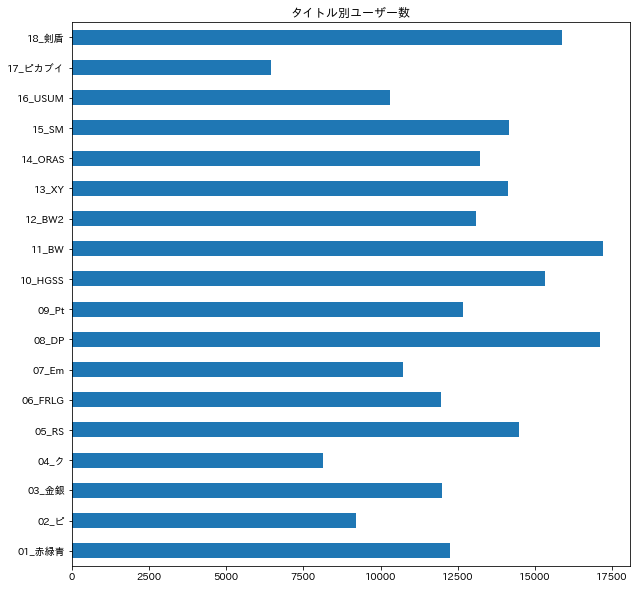

In [19]:
df[node_list].sum().sort_index().plot.barh(figsize=(10,10))
plt.title("タイトル別ユーザー数");

In [32]:
def plot_network(data,node_list, fig_size=(14, 14), file_name=None,title_color=False):
    """
    parameter:
    
    data:pandas.DataFrame
    node_list:ノードを作成したい列名のリスト
    
    return:
    pandas.DataFrame
    各ノードごとのjaccard係数がわかる
    """
    
    #jaccard係数の計算をしていく
    n1_list = []
    n2_list = []
    Union_list = []
    Intersection_list = []
    combination_list = list(itertools.combinations(list(node_list), 2))
    
    for (n1,n2) in combination_list:
        Union_df = data[(data[n1]==1) | (data[n2]==1)]
        Intersection_df =data[(data[n1]==1) & (data[n2]==1)]
        n1_list.append(n1)
        n2_list.append(n2)
        Union_list.append(Union_df.shape[0])
        Intersection_list.append(Intersection_df.shape[0])

    df_ja = pd.DataFrame({"n1":n1_list,
                 "n2":n2_list,
                 "Union":Union_list,
                 "Intersection":Intersection_list})
    df_ja["jaccard_value"] = df_ja["Intersection"] / df_ja["Union"]
    
    player_dict={} # 各タイトルのプレイヤー数を収納
    for gen in gen_dict.values():
        player_dict[gen] = data[gen].sum()
    

    G = nx.Graph() #グラフの作成
    G.add_nodes_from(node_list) #ノードの作成

    # エッジの追加
    for i in range(len(df_ja)):
        row_data = df_ja.iloc[i]
        G.add_edge(row_data['n1'], row_data['n2'], weight=row_data['jaccard_value'])

    plt.figure(figsize=fig_size) #グラフの表示
    pos = nx.circular_layout(G) #ネットワーク図の表示設定。circular_layoutを使用

    #ノードの描画上の大きさの設定。数が多いと比較が難しくなるので、差を強調している
    node_size=[(v-4000)**2*10000/(max(player_dict.values())**2) for v in player_dict.values()]
    def make_node_color(node_list):
        minor_change=['02_ピ','04_ク','07_Em','09_Pt', '12_BW2','16_USUM']
        remake=['06_FRLG', '10_HGSS','14_ORAS', '17_ピカブイ']
        color_list=[]
        for node in node_list:
            if node in minor_change:
                color = 3000
            elif node in remake:
                color = 6000
            else:
                color = 10000
            color_list.append(color)
        return color_list
    
    if title_color:
        node_color = make_node_color(node_list)
    else:
        node_color = node_size

    
    # グラフにノードを描画。ノードの色・大きさはここで設定
    nx.draw_networkx_nodes(G, pos, node_color=node_color,
                           cmap=plt.cm.Reds,
                           alpha=0.7,
                           node_size=node_size)

    # 日本語ラベル
    nx.draw_networkx_labels(G, pos, fontsize=20, font_family='IPAexGothic', font_weight="bold")

    # エッジの太さ調節.こちらも差を強調する
    edge_width = [np.exp(d["weight"]-0.3)**5 for (u, v, d) in G.edges(data=True)]
    nx.draw_networkx_edges(G, pos, alpha=0.4, edge_color=edge_width, width=edge_width,edge_cmap=plt.cm.Blues)
    
    plt.axis('off')
    
    if file_name !=None:
        plt.savefig(file_name, bbox_inches="tight")
    return df_ja

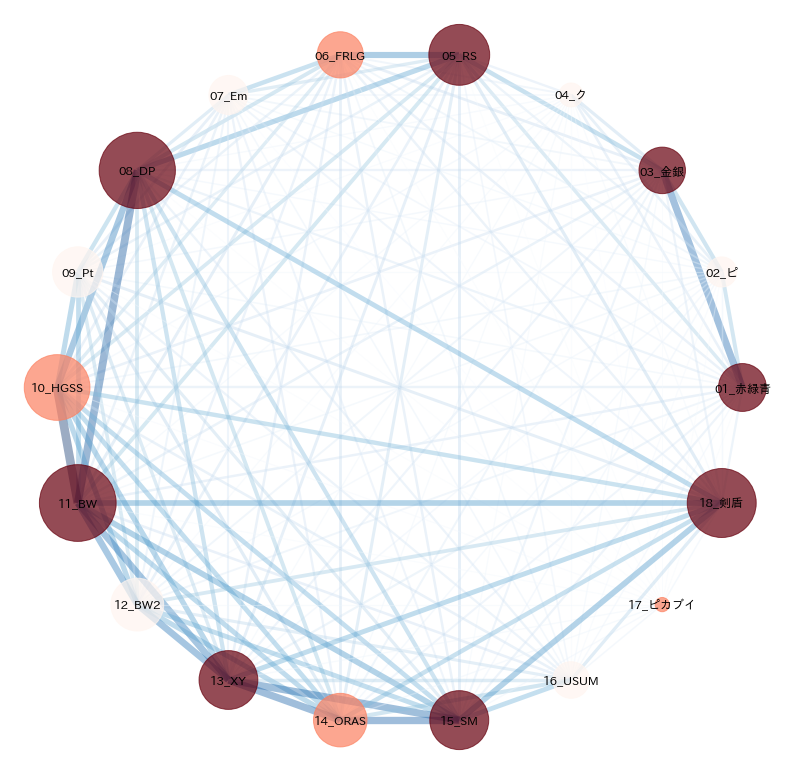

In [33]:
df_ja = plot_network(df
                     ,node_list
                     ,file_name="out.png"
                    ,title_color=True)

**見やすくするために行った処理**

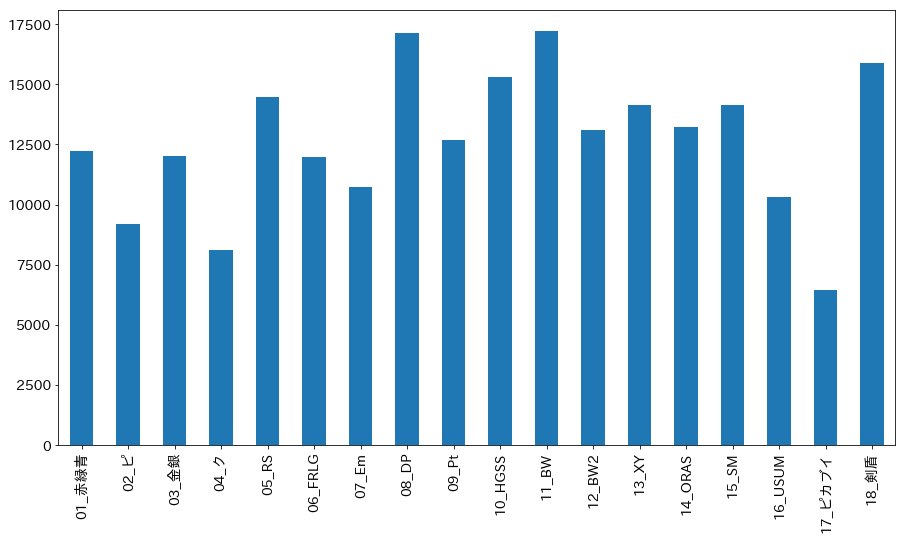

In [109]:
df[node_list].sum().plot.bar(figsize=(15,8),fontsize=14)

In [112]:
df_sum = df[node_list].sum()
max_node = df_sum.max()

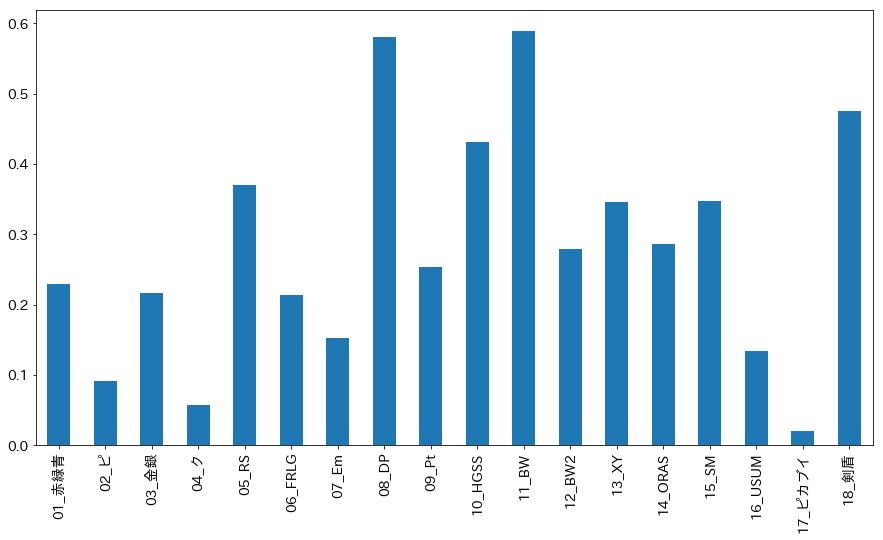

In [118]:
df_sum.map(lambda x:(x-4000)**2/(max_node)**2).plot.bar(figsize=(15,8),fontsize=14)